Analiza retencji
- w miesiącach (lepiej w dniach)
- w pierwszej wersji bez filtowania
- w drugiej wersji z filtrem po event_type == purchase
- eksperymenty kohort z ceną i liczbą transakacji

# 0. Wczytanie danych

In [36]:
import pandas as pd

# Wczytywanie danych eCommerce cosmetics
file_paths = [
    './data/cosmetics/2019-Oct.csv',
    './data/cosmetics/2019-Nov.csv',
    './data/cosmetics/2019-Dec.csv',
    './data/cosmetics/2020-Jan.csv',
    './data/cosmetics/2020-Feb.csv'
]

# Łączenie wielu plików w jeden DataFrame
dataframes = []
for path in file_paths:
    try:
        df = pd.read_csv(path)
        dataframes.append(df)
        print(f"{path} wczytano poprawnie, rozmiar: {len(df)} wierszy.")
    except Exception as e:
        print(f"Nie udało się wczytać {path}: {e}")

analiza1 = pd.concat(dataframes, ignore_index=True)
print(f"Łączny rozmiar danych: {len(analiza1)} wierszy, {analiza1.shape[1]} kolumn.")


./data/cosmetics/2019-Oct.csv wczytano poprawnie, rozmiar: 4102283 wierszy.
./data/cosmetics/2019-Nov.csv wczytano poprawnie, rozmiar: 4635837 wierszy.
./data/cosmetics/2019-Dec.csv wczytano poprawnie, rozmiar: 3533286 wierszy.
./data/cosmetics/2020-Jan.csv wczytano poprawnie, rozmiar: 4264752 wierszy.
./data/cosmetics/2020-Feb.csv wczytano poprawnie, rozmiar: 4156682 wierszy.
Łączny rozmiar danych: 20692840 wierszy, 9 kolumn.


In [32]:
analiza1.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cohort_month,event_month,cohort_index
0,2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10,0
1,2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10,0
2,2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10,2019-10,0
3,2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10,2019-10,0
4,2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10,2019-10,0


In [16]:
analiza1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


In [33]:
print(analiza1.isnull().sum())


event_time              0
event_type              0
product_id              0
category_id             0
category_code    20339246
brand             8757117
price                   0
user_id                 0
user_session         4598
cohort_month            0
event_month             0
cohort_index            0
dtype: int64


In [34]:
print(analiza1['event_type'].value_counts())
print(analiza1['brand'].nunique())


event_type
view                9657821
cart                5768333
remove_from_cart    3979679
purchase            1287007
Name: count, dtype: int64
273


# A1 . Analiza retencji w kohortach(all event_types)

In [ ]:
# Konwersja kolumny 'event_time' na typ datetime
analiza1['event_time'] = pd.to_datetime(analiza1['event_time'], errors='coerce')

# Pierwszy miesiąc aktywności użytkownika
# first_active_month = analiza1.groupby('user_id')['event_time'].min().dt.to_period('M')
analiza1['cohort_month'] = analiza1.groupby('user_id')['event_time'].transform('min').dt.to_period('M')


# Dodanie do danych
# analiza1['cohort_month'] = analiza1['user_id'].map(first_active_month)

# Dodanie indeksu kohortowego
analiza1['event_month'] = analiza1['event_time'].dt.to_period('M')
analiza1['cohort_index'] = (
    (analiza1['event_month'].dt.year - analiza1['cohort_month'].dt.year) * 12 +
    (analiza1['event_month'].dt.month - analiza1['cohort_month'].dt.month)
)


C:\Users\nazwa\AppData\Local\Temp\ipykernel_25988\2987927034.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_active_month = analiza1.groupby('user_id')['event_time'].min().dt.to_period('M')
C:\Users\nazwa\AppData\Local\Temp\ipykernel_25988\2987927034.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  analiza1['event_month'] = analiza1['event_time'].dt.to_period('M')


```Python
# Co jeśli nie było transakcji
analiza1['cohort_index'] = (
    (analiza1['event_month'].dt.year - analiza1['cohort_month'].dt.year) * 12 +
    (analiza1['event_month'].dt.month - analiza1['cohort_month'].dt.month)
).fillna(0).astype(int)
```

In [21]:
analiza1.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cohort_month,event_month,cohort_index
20692835,2020-02-29 23:59:32+00:00,view,5885416,1487580005092295511,NaN,grattol,6.27,622082947,fb29909b-6ef5-4662-b4ee-288e73e5dc10,2020-02,2020-02,0
20692836,2020-02-29 23:59:39+00:00,cart,5550686,1487580008145748965,NaN,NaN,1.11,459705611,05d2add3-01f7-47ee-8364-27341673227f,2019-10,2020-02,4
20692837,2020-02-29 23:59:45+00:00,view,5850628,1602943681873052386,NaN,grattol,5.24,622090043,ab7d349f-db5d-4790-8ab1-31e5c894459d,2020-02,2020-02,0
20692838,2020-02-29 23:59:54+00:00,view,5716351,1487580010872045658,NaN,irisk,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d,2020-02,2020-02,0
20692839,2020-02-29 23:59:59+00:00,view,5927709,1487580013950664926,NaN,de.lux,3.17,621669991,daa3c677-5360-4327-847e-d29658716b99,2020-02,2020-02,0


In [29]:
analiza1.event_type.unique()

array(['cart', 'view', 'remove_from_cart', 'purchase'], dtype=object)

In [20]:
analiza1.shape

(20692840, 12)

# A2. oblicznie retencji

In [22]:
# Liczba unikalnych użytkowników w każdej kohorcie i indeksie
cohort_data_1 = analiza1.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().reset_index()

# Pivot table do analizy
retention_1 = cohort_data_1.pivot(index='cohort_month', columns='cohort_index', values='user_id')

# Normalizacja względem pierwszego miesiąca (procent użytkowników powracających)
retention_percentage_1 = retention_1.div(retention_1.iloc[:, 0], axis=0) * 100


In [24]:
retention_1

cohort_index,0,1,2,3,4
cohort_month,,,,,
2019-10,399664.0,54796.0,36346.0,31750.0,26953.0
2019-11,313436.0,34347.0,21942.0,17424.0,NaN
2019-12,299461.0,27443.0,15609.0,NaN,NaN
2020-01,328938.0,33210.0,NaN,NaN,NaN
2020-02,297859.0,NaN,NaN,NaN,NaN


In [25]:
retention_percentage_1

cohort_index,0,1,2,3,4
cohort_month,,,,,
2019-10,100.0,13.710517,9.094139,7.944173,6.743915
2019-11,100.0,10.958218,7.000472,5.559030,NaN
2019-12,100.0,9.164132,5.212365,NaN,NaN
2020-01,100.0,10.096128,NaN,NaN,NaN
2020-02,100.0,NaN,NaN,NaN,NaN


3. Wizualizajca retencji

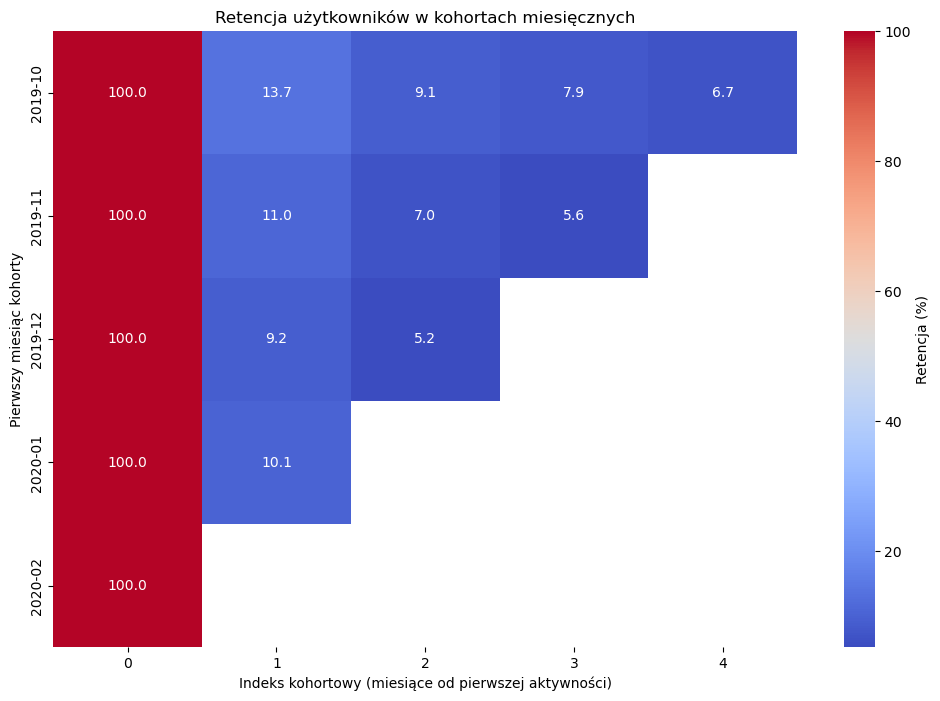

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmapa retencji
plt.figure(figsize=(12, 8))
sns.heatmap(retention_percentage_1, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Retencja (%)'})
plt.title('Retencja użytkowników w kohortach miesięcznych')
plt.xlabel('Indeks kohortowy (miesiące od pierwszej aktywności)')
plt.ylabel('Pierwszy miesiąc kohorty')
plt.show()


# B1. Analiza retencji w kohortach ( == purchase)

./data/cosmetics/2019-Oct.csv wczytano poprawnie, rozmiar: 4102283 wierszy.
./data/cosmetics/2019-Nov.csv wczytano poprawnie, rozmiar: 4635837 wierszy.
./data/cosmetics/2019-Dec.csv wczytano poprawnie, rozmiar: 3533286 wierszy.
./data/cosmetics/2020-Jan.csv wczytano poprawnie, rozmiar: 4264752 wierszy.
./data/cosmetics/2020-Feb.csv wczytano poprawnie, rozmiar: 4156682 wierszy.
Łączny rozmiar danych: 20692840 wierszy, 9 kolumn.
Tabela retencji użytkowników:


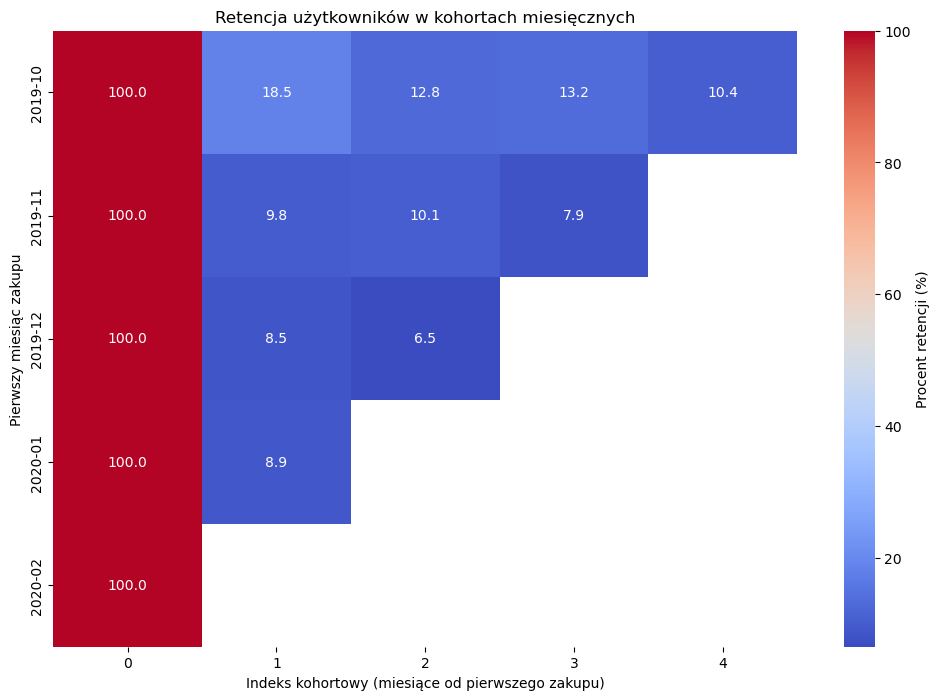

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytywanie danych eCommerce cosmetics
file_paths = [
    './data/cosmetics/2019-Oct.csv',
    './data/cosmetics/2019-Nov.csv',
    './data/cosmetics/2019-Dec.csv',
    './data/cosmetics/2020-Jan.csv',
    './data/cosmetics/2020-Feb.csv'
]

# Łączenie wielu plików w jeden DataFrame
dataframes = []
for path in file_paths:
    try:
        df = pd.read_csv(path)
        dataframes.append(df)
        print(f"{path} wczytano poprawnie, rozmiar: {len(df)} wierszy.")
    except Exception as e:
        print(f"Nie udało się wczytać {path}: {e}")

analiza2 = pd.concat(dataframes, ignore_index=True)
print(f"Łączny rozmiar danych: {len(analiza2)} wierszy, {analiza2.shape[1]} kolumn.")

# Filtrowanie tylko użytkowników, którzy dokonali zakupu
analiza2 = analiza2[analiza2['event_type'] == 'purchase']

# Konwersja event_time na datetime (upewniamy się, że jest w odpowiednim formacie)
analiza2['event_time'] = pd.to_datetime(analiza2['event_time'], errors='coerce')

# Usunięcie strefy czasowej, jeśli jest obecna
analiza2['event_time'] = analiza2['event_time'].dt.tz_localize(None)

# Pierwszy zakup każdego użytkownika
first_purchase_df_2 = analiza2.groupby('user_id')['event_time'].min().reset_index()

# Dodanie kolumny miesiąca pierwszego zakupu
first_purchase_df_2['first_purchase_month'] = first_purchase_df_2['event_time'].dt.to_period('M')

# Łączenie pierwszego zakupu z głównym DataFrame
analiza2 = analiza2.merge(first_purchase_df_2[['user_id', 'first_purchase_month']], on='user_id')

# Dodanie indeksu kohortowego do analizy
analiza2['cohort_index_2'] = (analiza2['event_time'].dt.to_period('M') - 
                              analiza2['first_purchase_month']).apply(lambda x: x.n)

# Obliczanie retencji (zakładając, że 'cohort_index_2' jest liczba miesięcy od pierwszego zakupu)
retention_2 = analiza2.groupby(['first_purchase_month', 'cohort_index_2'])['user_id'].nunique().reset_index()

# Obliczanie liczby użytkowników w pierwszym miesiącu zakupu (dla późniejszego obliczenia procentu retencji)
retention_2['total_users_in_cohort'] = retention_2.groupby('first_purchase_month')['user_id'].transform('first')

# Obliczanie procentu retencji
retention_2['retention_percentage'] = (retention_2['user_id'] / retention_2['total_users_in_cohort']) * 100

# Tworzenie pivot table do wizualizacji
retention_pivot = retention_2.pivot_table(index='first_purchase_month', columns='cohort_index_2', 
                                         values='retention_percentage', aggfunc='mean')

# Wizualizacja retencji w formie heatmapy
plt.figure(figsize=(12, 8))
sns.heatmap(retention_pivot, annot=True, fmt='.1f', cmap='coolwarm', cbar_kws={'label': 'Procent retencji (%)'})
plt.title('Retencja użytkowników w kohortach miesięcznych')
plt.xlabel('Indeks kohortowy (miesiące od pierwszego zakupu)')
plt.ylabel('Pierwszy miesiąc zakupu')
plt.show()


! Poprawić nazwy zmiennych, brak konsekwencji (retention_pivot)

In [64]:
analiza2

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,first_purchase_month,cohort_index_2
0,2019-10-01 00:06:35,purchase,5619862,1487580006895846315,NaN,runail,5.32,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe,2019-10,0
1,2019-10-01 00:06:35,purchase,5619866,1487580006895846315,NaN,runail,2.86,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe,2019-10,0
2,2019-10-01 00:06:35,purchase,5696184,1487580005134238553,NaN,runail,2.38,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe,2019-10,0
3,2019-10-01 00:06:35,purchase,5706784,1487580005092295511,NaN,runail,4.44,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe,2019-10,0
4,2019-10-01 00:06:35,purchase,5723503,1487580005134238553,NaN,runail,2.62,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe,2019-10,0
...,...,...,...,...,...,...,...,...,...,...,...
1287002,2020-02-29 23:46:01,purchase,5896420,1487580006300255120,NaN,jessnail,49.21,620865261,64389dba-26c4-f328-6972-166a48654eaa,2020-02,0
1287003,2020-02-29 23:54:44,purchase,5692863,1487580007910867929,NaN,yoko,7.83,548866558,199869f5-3a22-4a47-8678-7c343d09bb8e,2020-02,0
1287004,2020-02-29 23:54:44,purchase,5802432,1487580009286598681,NaN,NaN,0.32,548866558,199869f5-3a22-4a47-8678-7c343d09bb8e,2020-02,0
1287005,2020-02-29 23:54:44,purchase,5896788,1783999068909863670,NaN,staleks,4.75,548866558,199869f5-3a22-4a47-8678-7c343d09bb8e,2020-02,0


user_id to tak naprawdę liczba użytkownikó

In [61]:
retention_2

,first_purchase_month,cohort_index_2,user_id,total_users_in_cohort,retention_percentage
0,2019-10,0,25762,25762,100.000000
1,2019-10,1,4763,25762,18.488471
2,2019-10,2,3293,25762,12.782393
3,2019-10,3,3399,25762,13.193851
4,2019-10,4,2692,25762,10.449499
5,2019-11,0,26761,26761,100.000000
6,2019-11,1,2618,26761,9.782893
7,2019-11,2,2716,26761,10.149098
8,2019-11,3,2119,26761,7.918239
9,2019-12,0,19702,19702,100.000000


In [66]:
retention_2.shape

(15, 5)

In [63]:
retention_pivot

cohort_index_2,0,1,2,3,4
first_purchase_month,,,,,
2019-10,100.0,18.488471,12.782393,13.193851,10.449499
2019-11,100.0,9.782893,10.149098,7.918239,NaN
2019-12,100.0,8.516902,6.456197,NaN,NaN
2020-01,100.0,8.860821,NaN,NaN,NaN
2020-02,100.0,NaN,NaN,NaN,NaN


# Inne analizy kohortowe (cena)

# I2. Wstępne przetwarzanie danych

In [3]:
# Konwersja dat na typ datetime
data['event_time'] = pd.to_datetime(data['event_time'], utc=True)

# Dodanie kolumny z miesiącem kohortowym
data['cohort_month'] = data['event_time'].dt.to_period('M')

# Filtracja danych (opcjonalnie - zależy od potrzeb analizy)
data = data.dropna(subset=['price', 'user_id'])  # Usunięcie wierszy z brakującymi cenami lub użytkownikami


C:\Users\nazwa\AppData\Local\Temp\ipykernel_25988\4131518453.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['cohort_month'] = data['event_time'].dt.to_period('M')


In [4]:
data.shape

(20692840, 10)

3. Tworzenie kohort

In [5]:
# Pierwszy miesiąc aktywności użytkownika
first_purchase = data.groupby('user_id')['cohort_month'].min()

# Łączenie z danymi
data = data.merge(first_purchase, on='user_id', suffixes=('', '_cohort'))

# Obliczanie indeksu kohortowego (liczba miesięcy od pierwszej aktywności)
data['cohort_index'] = (
    (data['cohort_month'].dt.year - data['cohort_month_cohort'].dt.year) * 12 +
    (data['cohort_month'].dt.month - data['cohort_month_cohort'].dt.month)
)

In [9]:
data.tail()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cohort_month,cohort_month_cohort,cohort_index
20692835,2020-02-29 23:59:32+00:00,view,5885416,1487580005092295511,NaN,grattol,6.27,622082947,fb29909b-6ef5-4662-b4ee-288e73e5dc10,2020-02,2020-02,0
20692836,2020-02-29 23:59:39+00:00,cart,5550686,1487580008145748965,NaN,NaN,1.11,459705611,05d2add3-01f7-47ee-8364-27341673227f,2020-02,2019-10,4
20692837,2020-02-29 23:59:45+00:00,view,5850628,1602943681873052386,NaN,grattol,5.24,622090043,ab7d349f-db5d-4790-8ab1-31e5c894459d,2020-02,2020-02,0
20692838,2020-02-29 23:59:54+00:00,view,5716351,1487580010872045658,NaN,irisk,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d,2020-02,2020-02,0
20692839,2020-02-29 23:59:59+00:00,view,5927709,1487580013950664926,NaN,de.lux,3.17,621669991,daa3c677-5360-4327-847e-d29658716b99,2020-02,2020-02,0


In [8]:
data.shape

(20692840, 12)

# I3. Oblicznie metryk

In [10]:
# Grupowanie po kohorcie i indeksie kohortowym
cohort_data = data.groupby(['cohort_month_cohort', 'cohort_index'])['price'].mean().reset_index()

# Pivot table dla analizy
average_price = cohort_data.pivot(index='cohort_month_cohort', columns='cohort_index', values='price')
print(average_price)

cohort_index                 0         1         2         3         4
cohort_month_cohort                                                   
2019-10               8.534920  6.746435  7.024913  6.929446  6.621151
2019-11               9.235870  7.889219  7.468728  7.216741       NaN
2019-12              10.400004  8.274834  7.771974       NaN       NaN
2020-01              10.111936  7.675347       NaN       NaN       NaN
2020-02              10.254810       NaN       NaN       NaN       NaN


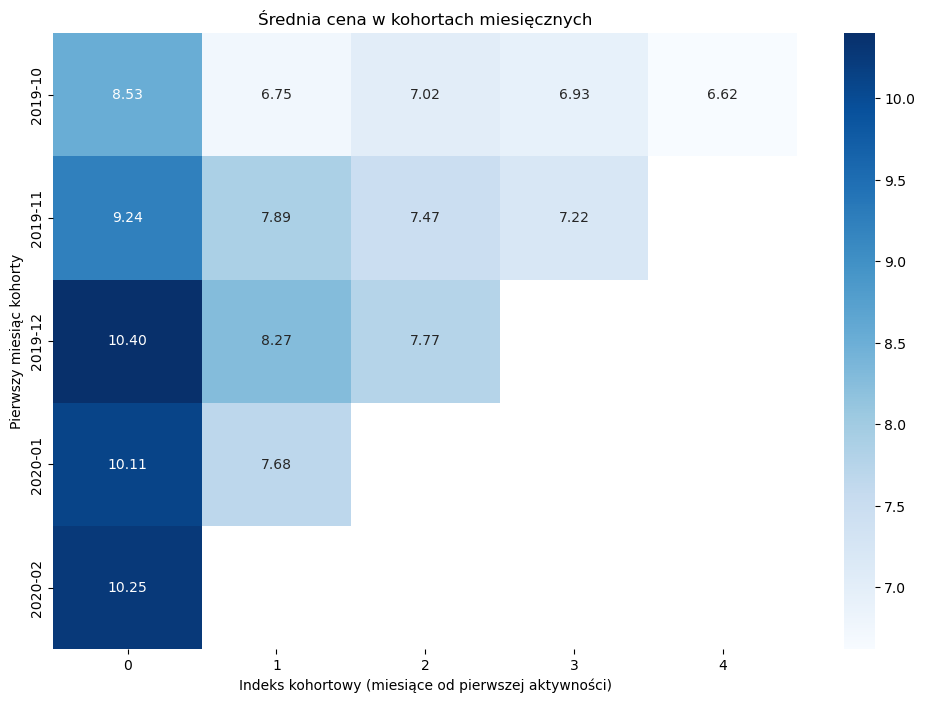

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wizualizacja danych kohortowych
plt.figure(figsize=(12, 8))
sns.heatmap(data=average_price, annot=True, fmt=".2f", cmap='Blues')
plt.title('Średnia cena w kohortach miesięcznych')
plt.xlabel('Indeks kohortowy (miesiące od pierwszej aktywności)')
plt.ylabel('Pierwszy miesiąc kohorty')
plt.show()

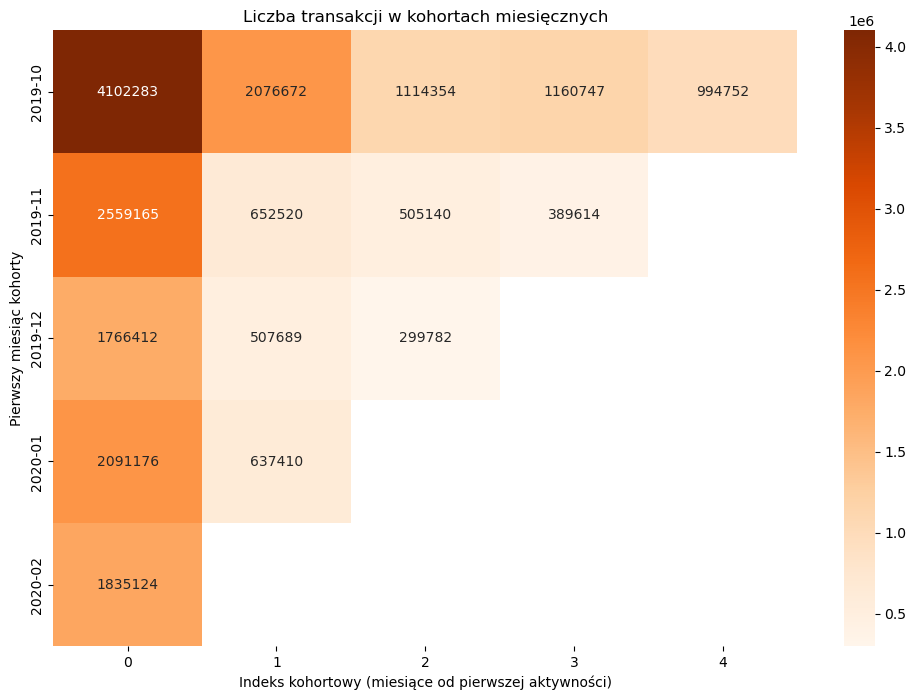

In [12]:
transaction_counts = data.groupby(['cohort_month_cohort', 'cohort_index'])['user_id'].count().reset_index()
transaction_pivot = transaction_counts.pivot(index='cohort_month_cohort', columns='cohort_index', values='user_id')

plt.figure(figsize=(12, 8))
sns.heatmap(data=transaction_pivot, annot=True, fmt=".0f", cmap='Oranges')
plt.title('Liczba transakcji w kohortach miesięcznych')
plt.xlabel('Indeks kohortowy (miesiące od pierwszej aktywności)')
plt.ylabel('Pierwszy miesiąc kohorty')
plt.show()
